Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
from tqdm import notebook
from matplotlib import pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score
import gensim.downloader as api


In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')
data.info()
display(data.head())
display(data[data['toxic'] == 1].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


,text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1


0    143346
1     16225
Name: toxic, dtype: int64

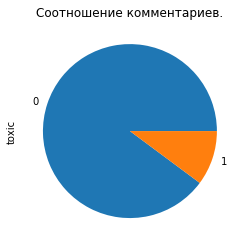

In [3]:
display(data['toxic'].value_counts())
data['toxic'].value_counts().plot(kind='pie')
plt.title('Соотношение комментариев.')
plt.show()

Соотношение токсичных комментариев к остальным почти как 1 к 10. Это не очень сбаллансировано. Возможно при обучении нам нужно будет сделать upsampling или downsamping.

In [4]:
assert data.duplicated().sum() == 0, "Duplicates is data."

Дубикаты отсутствуют.

# 2. Обучение

In [5]:
stemmer = SnowballStemmer("english")
def stem_text(text):
    stemed_text = []
    for word in text.split():
        stemed_text.append(stemmer.stem(word))
    return ' '.join(stemed_text)

data['lemm_text'] = data['text'].apply(stem_text)
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explan whi the edit made under my usernam hard...
1,D'aww! He matches this background colour I'm s...,0,d'aww! he match this background colour i'm see...
2,"Hey man, I'm really not trying to edit war. It...",0,"hey man, i'm realli not tri to edit war. it ju..."
3,"""\nMore\nI can't make any real suggestions on ...",0,""" more i can't make ani real suggest on improv..."
4,"You, sir, are my hero. Any chance you remember...",0,"you, sir, are my hero. ani chanc you rememb wh..."


In [6]:
features = data['lemm_text']
target = data['toxic']

features_train, features_tmp, target_train, target_tmp = train_test_split(
    features, target, test_size=0.3, random_state=12345
)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_tmp, target_tmp, test_size=0.5, random_state=12345
)
assert (
    features_train.shape[0] 
    + features_valid.shape[0] 
    + features_test.shape[0]
) == features.shape[0], 'Wrong split'

features_train.shape,  target_train.shape

((111699,), (111699,))

## TF IDF Vectorizer and LogisticRegression 

In [7]:
nltk.download('stopwords')
stop_words_eng = set(stopwords.words('english'))
tf_idf_vectorizer = TfidfVectorizer(stop_words=stop_words_eng)
tf_idf_vectorizer.fit(features_train)
tfidf_features_train = tf_idf_vectorizer.transform(features_train)
tfidf_features_valid = tf_idf_vectorizer.transform(features_valid)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
model = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced')
model.fit(tfidf_features_train, target_train)
predicted_train = model.predict(tfidf_features_train)
predicted_valid = model.predict(tfidf_features_valid)
f1 = f1_score(target_valid, predicted_valid)

print(f'F1 score on train data {f1_score(target_train, predicted_train):.3f}')
print(f'Precision on train data {precision_score(target_train, predicted_train)}')
print(f'Recall on train data {recall_score(target_train, predicted_train)}')
print()
print(f'F1 score on valid data {f1:.3f}')
print(f'Precision on valid data {precision_score(target_valid, predicted_valid)}')
print(f'Recall on valid data {recall_score(target_valid, predicted_valid)}')

F1 score on train data 0.836
Precision on train data 0.7366337962031261
Recall on train data 0.9676594994712725

F1 score on valid data 0.749
Precision on valid data 0.6702369360597209
Recall on valid data 0.8497942386831275


## Вывод
Мы почти достигли нашей цели в скоре F1 на  TF IDF Vectorizer и линейной регрессии.
Если объеденить трэй и валид и обучить модель на них, думаю цель будет достигнута.

Попробуем еще один способ векторизации.

## Gensim and LogisticRegression 

In [9]:
# Используем предобученную модель Gensim
vectorizer = api.load('glove-twitter-100')
print(vectorizer.most_similar('hello'))
print(vectorizer.get_vector('hello'))

[('hey', 0.8247329592704773), ('hi', 0.790764570236206), ('welcome', 0.7881895303726196), ('dear', 0.7727690935134888), ('morning', 0.7323523759841919), ('miss', 0.7135189771652222), ('thanks', 0.7124098539352417), ('yes', 0.7090976238250732), ('thank', 0.7074065208435059), ('babe', 0.691576361656189)]
[ 0.55793    0.10748   -0.57491    0.4877    -0.37792   -0.036457
  1.0581     0.059584  -0.19582   -0.41366    0.054969   0.10674
 -2.7076    -0.50818   -0.47456    0.32746    0.41643   -0.53607
 -0.24822   -0.63456   -0.075781  -1.1904    -0.72504    0.19499
  0.029645  -0.98157    0.27081    0.32472    0.51154   -0.86702
 -0.36342    0.14098   -0.44251    0.24804    0.14021   -0.042186
  0.10408    0.23267    0.26663    0.40316   -0.91011    0.049339
  0.14842    0.70496   -0.013448   0.35591   -0.23494   -0.83828
  0.0069803  0.44702   -0.27031    0.0032742  0.13265   -0.68583
  0.90147    0.60725   -0.1849     0.086123  -0.1693    -0.48741
  0.33445   -0.10119   -0.054273  -0.35999 

In [10]:
def get_phrase_embedding(words):
    """
    Convert phrase to a vector by aggregating it's word embeddings. See description above.
    """  
    vector = np.zeros([vectorizer.vector_size], dtype='float32')
    counter = 0
    for word in words:
        if word in vectorizer:
            counter += 1
            word_vector = vectorizer.get_vector(word)
            vector += word_vector
    return vector / max(counter, 1)


In [11]:
gensim_features_train = []
for words in notebook.tqdm(features_train):
    gensim_features_train.append(get_phrase_embedding(words))
    
print(len(gensim_features_train))

gensim_features_valid = []
for words in notebook.tqdm(features_valid):
    gensim_features_valid.append(get_phrase_embedding(words))
    
print(len(gensim_features_valid))


111699



23936


In [12]:
model = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced')
model.fit(gensim_features_train, target_train)
predicted_train = model.predict(gensim_features_train)
predicted_valid = model.predict(gensim_features_valid)
f1 = f1_score(target_valid, predicted_valid)

print(f'F1 score on train data {f1_score(target_train, predicted_train):.3f}')
print(f'Precision on train data {precision_score(target_train, predicted_train)}')
print(f'Recall on train data {recall_score(target_train, predicted_train)}')
print()
print(f'F1 score on valid data {f1:.3f}')
print(f'Precision on valid data {precision_score(target_valid, predicted_valid)}')
print(f'Recall on valid data {recall_score(target_valid, predicted_valid)}')

F1 score on train data 0.393
Precision on train data 0.27517609996106335
Recall on train data 0.6850546351780049

F1 score on valid data 0.397
Precision on valid data 0.2769884043769394
Recall on valid data 0.6979423868312757


## Вывод
С использованием Gensim нам не удалось добиться значительной точности.

Поэтому остановимся на TF IDF Vectorizer.

In [13]:
features_train = pd.concat([features_train, features_valid])
target_train = pd.concat([target_train, target_valid])

nltk.download('stopwords')
stop_words_eng = set(stopwords.words('english'))
tf_idf_vectorizer = TfidfVectorizer(stop_words=stop_words_eng)
tf_idf_vectorizer.fit(features_train)


features_train = tf_idf_vectorizer.transform(features_train)

features_test = tf_idf_vectorizer.transform(features_test)

model = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced')
model.fit(features_train, target_train)
predicted_train = model.predict(features_train)
predicted_test = model.predict(features_test)
f1 = f1_score(target_test, predicted_test)

print(f'F1 score on train data {f1_score(target_train, predicted_train):.3f}')
print(f'Precision on train data {precision_score(target_train, predicted_train)}')
print(f'Recall on train data {recall_score(target_train, predicted_train)}')
print()
print(f'F1 score on valid data {f1:.3f}')
print(f'Precision on valid data {precision_score(target_test, predicted_test)}')
print(f'Recall on valid data {recall_score(target_test, predicted_test)}')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


F1 score on train data 0.832
Precision on train data 0.7320405464962538
Recall on train data 0.9644360574829438

F1 score on valid data 0.758
Precision on valid data 0.6787330316742082
Recall on valid data 0.8581937065794851


# 3. Выводы

Целевое значение F1 в 0.75 достигнуто. Что это значит? 

Мы имеем значение Precizion - 0.67, т.е. если наша модель отметит комментарий как токчичный, то это так и есть с вероятностью 67%.

Значение Recall - 0.85, говорит о том, что наша модель распознает 85% токичных комментариев, и только 15% смогут обойти нашу модель.

В итоге результат был достигнут за счет сочетания токенизатора - SnowballStemmer, векторизатора - TfidfVectorizer и старой доброй логистической регрессии.